In [ ]:
# LightGBM and XGB for regression exercise
# author: Serigne
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

# Stacked Regressions to predict House Prices

In [39]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt # Matlab-style plotting
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

# avoid warning from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
# limit float output
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

## 1. Access and Explore Data

In [2]:
# load data
train = pd.read_csv('/Users/pliu/Downloads/all/train.csv')
test = pd.read_csv('/Users/pliu/Downloads/all/test.csv')

In [8]:
# check the dataset
train.shape # (1460, 81)
test.shape # (1459, 80)
train.head()
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
# save and drop the Id column from the dataset
train_ID, test_ID = train['Id'], test['Id']
train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)

In [11]:
test_ID.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

## 2. Data Processing

### 2.1 Outliers

In [16]:
def plot_scatter(col_1, col_2):
    fig, ax = plt.subplots()
    ax.scatter(x=train[col_1], y=train[col_2])
    plt.ylabel(col_2, fontsize=13)
    plt.xlabel(col_1, fontsize=13)
    plt.show()

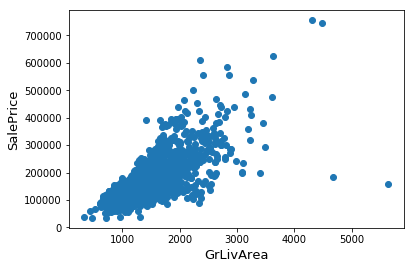

In [17]:
# GrLivArea: Above grade (ground) living area square feet
plot_scatter('GrLivArea', 'SalePrice')

In [18]:
# delete outliers
train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index,inplace=True)

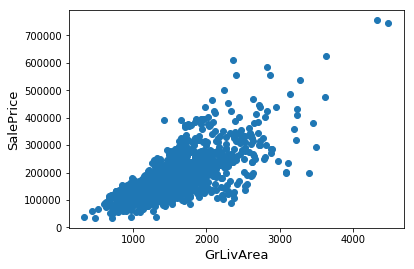

In [19]:
# check if outliers are removed
plot_scatter('GrLivArea', 'SalePrice')

## 2.2 Target Variable 

#### distribution of target variable

In [34]:
def distribution_plot(col):
    sns.distplot(train[col], fit=norm)
    # get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    
    print('\n mu = {:.3f} and sigma = {:.3f}'.format(mu, sigma))
    # print ('\n mu = and sigma = '.format(mu, sigma))
    
    # now plot the distribution
    # add legend, label and title
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
    plt.ylabel('Frequency')
    plt.title(col + ' distribution')
    
    # Get also the QQ plot
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    plt.show()


 mu = 180932.919 and sigma = 79467.789


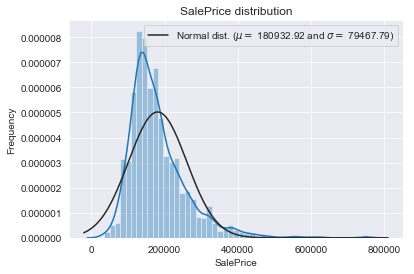

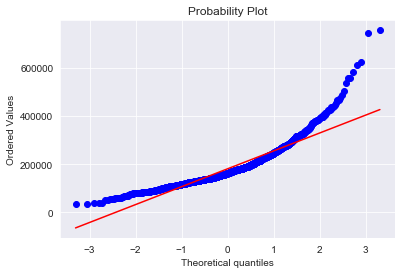

In [35]:
distribution_plot('SalePrice') # the target is right skewed

#### log transformation of target variable

In [37]:
# use numpy log1p to apply log(1+x) to all elements in the col
train['SalePrice'] = np.log1p(train['SalePrice'])


 mu = 12.024 and sigma = 0.400


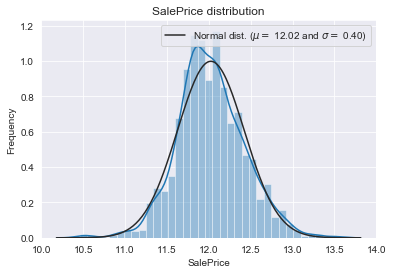

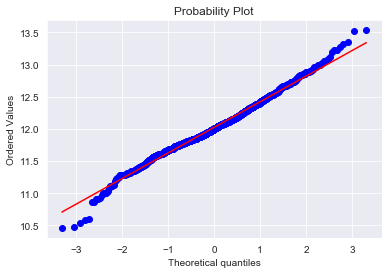

In [40]:
distribution_plot('SalePrice') # the target is right skewed

## 2.3 Missing Data

#### concatenate train and test

In [49]:
# stacking vertically
n_train, n_test = train.shape[0], test.shape[0]
# y_train = train.SalePrice # pandas.core.series.Series
y_train = train.SalePrice.values
type(y_train) #numpy.ndarray
all_data = pd.concat((train, test)).reset_index(drop=True)
# reset_index: after vertical concatenation, if you get an index of [0,n) by [0,m)
# all you need to do us call reset_index: pd.concat([a,b]).reset_index(drop=True)
all_data.drop('SalePrice', inplace=True, axis=1)
all_data.shape

(2917, 79)

#### Missing Data

In [53]:
# Missing value statistics
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
type(all_data_na) # pandas.core.series.Series
# convert pandas.core.series.Series to pd.DataFrame
missing = pd.DataFrame({'Missing Ratio':all_data_na})
missing.head(20)

,Missing Ratio
PoolQC,99.69
MiscFeature,96.40
Alley,93.21
Fence,80.43
FireplaceQu,48.68
LotFrontage,16.66
GarageQual,5.45
GarageCond,5.45
GarageFinish,5.45
GarageYrBlt,5.45


In [62]:
# Missing Data Visualization
def missing_plot():
    f, ax = plt.subplots(figsize=(15, 12)) # set figure size
    plt.xticks(rotation='90') # x labels display vertically
    sns.barplot(x=all_data_na.index, y=all_data_na) # init a sns.barplot(x=, y=)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percentage of missing values', fontsize=15)
    plt.title('Percentage of missing data by feature', fontsize=15)

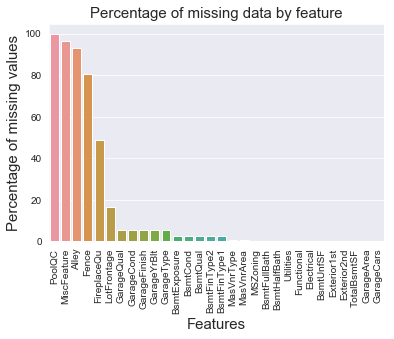

In [63]:
missing_plot()

In [64]:
# Missing Data Visualization
def missing_plot():
    #f, ax = plt.subplots()#figsize=(15, 12)
    plt.xticks(rotation='90')
    sns.barplot(x=all_data_na.index, y=all_data_na)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percentage of missing values', fontsize=15)
    plt.title('Percentage of missing data by feature', fontsize=15)

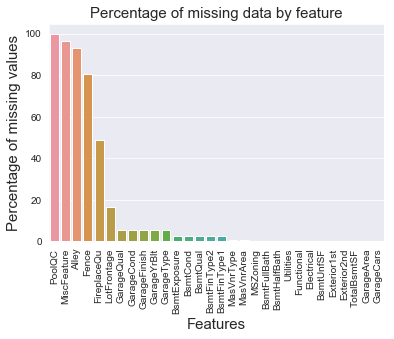

In [65]:
missing_plot()